In [16]:
import fiona

gdb_path = "/Users/eddie/Downloads/NFHL_48_20250710/NFHL_48_20250710.gdb"

layers = fiona.listlayers(gdb_path)
print(layers)

['S_NODES', 'S_HWM', 'S_SUBMITTAL_INFO', 'L_PAN_REVIS', 'S_SUBBASINS', 'L_MT2_LOMR', 'S_WTR_LN', 'S_CST_TSCT_LN', 'S_LABEL_PT', 'L_PROFIL_LABEL', 'S_RIV_MRK', 'S_TSCT_BASLN', 'S_LEVEE', 'L_XS_ELEV', 'S_BASE_INDEX', 'S_PROFIL_BASLN', 'S_LIMWA', 'S_WTR_AR', 'S_FLD_HAZ_LN', 'L_MTG_POC', 'S_LOMR', 'L_MANNINGSN', 'S_DATUM_CONV_PT', 'S_HYDRO_REACH', 'L_COMM_REVIS', 'S_POL_AR', 'L_XS_STRUCT', 'S_BFE', 'L_SOURCE_CIT', 'S_STN_START', 'L_CST_MODEL', 'S_LABEL_LD', 'L_SUMMARY_ELEVATIONS', 'S_GEN_STRUCT', 'S_GAGE', 'L_MEETINGS', 'L_COMM_INFO', 'L_PROFIL_PANEL', 'L_CST_TSCT_ELEV', 'S_FIRM_PAN', 'STUDY_INFO', 'L_PROFIL_BKWTR_EL', 'S_FLD_HAZ_AR', 'L_SUMMARY_DISCHARGES', 'S_TRNSPORT_LN', 'L_POL_FHBM', 'S_XS']


In [ ]:
import geopandas as gpd

layer_name = 'S_Fld_Haz_Ar'

flood_zones = gpd.read_file(gdb_path, layer=layer_name)
print(flood_zones.columns)


Index(['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 'FLD_ZONE',
       'ZONE_SUBTY', 'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
       'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT',
       'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID', 'SHAPE_Length',
       'SHAPE_Area', 'geometry'],
      dtype='object')


In [ ]:

counties_fp = '/Users/eddie/Downloads/tl_2024_us_county'  
counties = gpd.read_file(counties_fp)
texas_counties = counties[counties['STATEFP'] == '48']
counties = texas_counties

In [29]:
high_risk = flood_zones[flood_zones['FLD_ZONE'].isin(['A', 'AE', 'AO', 'AH'])]
if high_risk.crs != counties.crs:
    high_risk = high_risk.to_crs(counties.crs)

In [30]:
intersect = gpd.overlay(counties, high_risk, how='intersection')

In [31]:
intersect['flood_area'] = intersect.to_crs("EPSG:3083").geometry.area
counties['county_area'] = counties.to_crs("EPSG:3083").geometry.area

In [32]:
flood_area_by_county = intersect.groupby('GEOID')['flood_area'].sum().reset_index()

In [33]:
counties = counties.merge(flood_area_by_county, on='GEOID', how='left')
counties['flood_area'] = counties['flood_area'].fillna(0)
counties['flood_pct'] = (counties['flood_area'] / counties['county_area']) * 100


In [34]:
print(counties)

    STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ       NAME  \
0        48      327  01383949  48327  0500000US48327     Menard   
1        48      189  01383880  48189  0500000US48189       Hale   
2        48      011  01383791  48011  0500000US48011  Armstrong   
3        48      057  01383814  48057  0500000US48057    Calhoun   
4        48      077  01383824  48077  0500000US48077       Clay   
..      ...      ...       ...    ...             ...        ...   
249      48      205  01383888  48205  0500000US48205    Hartley   
250      48      249  01383910  48249  0500000US48249  Jim Wells   
251      48      505  01384038  48505  0500000US48505     Zapata   
252      48      453  01384012  48453  0500000US48453     Travis   
253      48      227  01383899  48227  0500000US48227     Howard   

             NAMELSAD LSAD CLASSFP  MTFCC  ... METDIVFP FUNCSTAT       ALAND  \
0       Menard County   06      H1  G4020  ...     None        A  2336237980   
1         Hale County  

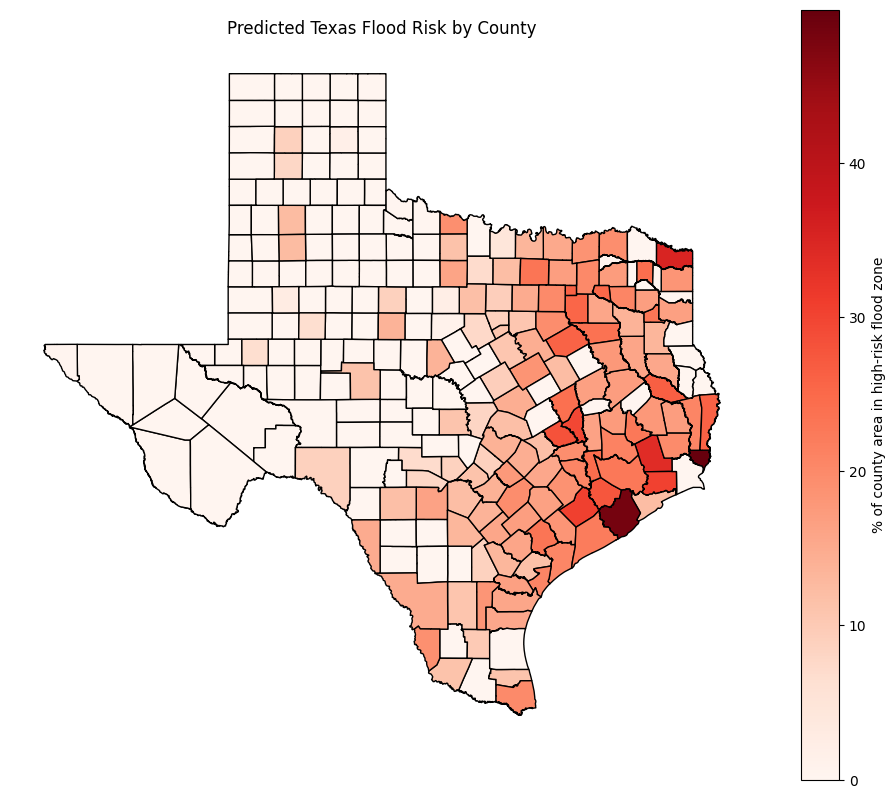

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
counties.plot(column='flood_pct',
              cmap='Reds',
              legend=True,
              edgecolor='black',
              ax=ax,
              legend_kwds={'label': "% of county area in high-risk flood zone"})

ax.set_title("Predicted Texas Flood Risk by County")
ax.axis('off')
plt.show()
